<a href="https://colab.research.google.com/github/NancyBudgujjar/brain_tumor/blob/main/LSTM_brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import pickle

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

In [4]:
rot = tf.keras.layers.RandomRotation(factor=0.2)
flip = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")

def augment(images):
    for i in range(len(images)):
        flipped = flip(images[i])
        images[i] = rot(flipped)

    return images

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#import os
#os.chdir('/content/drive/MyDrive/projects/Brain_tumor')
#db="/content/drive/MyDrive/projects/Brain_tumor"

In [7]:
#labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
labels = ['glioma_tumor','no_tumor','pituitary_tumor']
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/project/Brain_tumor','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        #img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        X_train.append(img)
        y_train.append(i)

100%|██████████| 827/827 [00:12<00:00, 65.76it/s] 


In [8]:
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/project/Brain_tumor','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        #img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 84/84 [00:20<00:00,  4.20it/s]


In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [10]:
#X_train = np.vstack(X_train)
X_train = np.vstack((X_train, augment(X_train)))

In [11]:
y_train = np.vstack((y_train, y_train.copy()))

In [12]:
X_train.shape, y_train.shape

((4674, 150, 150, 3), (4674, 3))

In [13]:
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_test.shape

((3739, 150, 150, 3), (935, 150, 150, 3))

In [16]:
r50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [17]:
X_train_preds = r50.predict(X_train)

117/117 [==============================] - 293s 2s/step


In [18]:
X_test_preds = r50.predict(X_test)

30/30 [==============================] - 70s 2s/step


In [19]:
X_train_preds.shape, X_test_preds.shape

((3739, 5, 5, 2048), (935, 5, 5, 2048))

In [20]:
X_train_features = np.zeros((3739, 1, 51200))
for i in range(3739): #5875
    X_train_features[i] = X_train_preds[i].reshape((1, 51200))
                            #653
X_test_features = np.zeros((935, 1, 51200))
for i in range(935):                                 #100352
    X_test_features[i] = X_test_preds[i].reshape((1, 51200))

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(512, input_shape=(1, 51200), activation='relu', return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            105908224 
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            787456    
                                                                 
 dropout_1 (Dropout)         (None, 1, 256)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            197120    
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                4

In [23]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [24]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("bestomodelo.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [25]:
history = model.fit(X_train_features, y_train, validation_split=0.1, epochs=12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
106/106 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.6021
Epoch 1: val_accuracy improved from -inf to 0.86364, saving model to bestomodelo.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


106/106 [==============================] - 223s 2s/step - loss: 0.8983 - accuracy: 0.6021 - val_loss: 0.3998 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 2/12
106/106 [==============================] - ETA: 0s - loss: 0.4349 - accuracy: 0.8547
Epoch 2: val_accuracy improved from 0.86364 to 0.90642, saving model to bestomodelo.h5
106/106 [==============================] - 227s 2s/step - loss: 0.4349 - accuracy: 0.8547 - val_loss: 0.3157 - val_accuracy: 0.9064 - lr: 0.0010
Epoch 3/12
106/106 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9218
Epoch 3: val_accuracy improved from 0.90642 to 0.92781, saving model to bestomodelo.h5
106/106 [==============================] - 227s 2s/step - loss: 0.2471 - accuracy: 0.9218 - val_loss: 0.2401 - val_accuracy: 0.9278 - lr: 0.0010
Epoch 4/12
106/106 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9516
Epoch 4: val_accuracy improved from 0.92781 to 0.96524, saving model to bestomodelo.h5
106/106 [=======

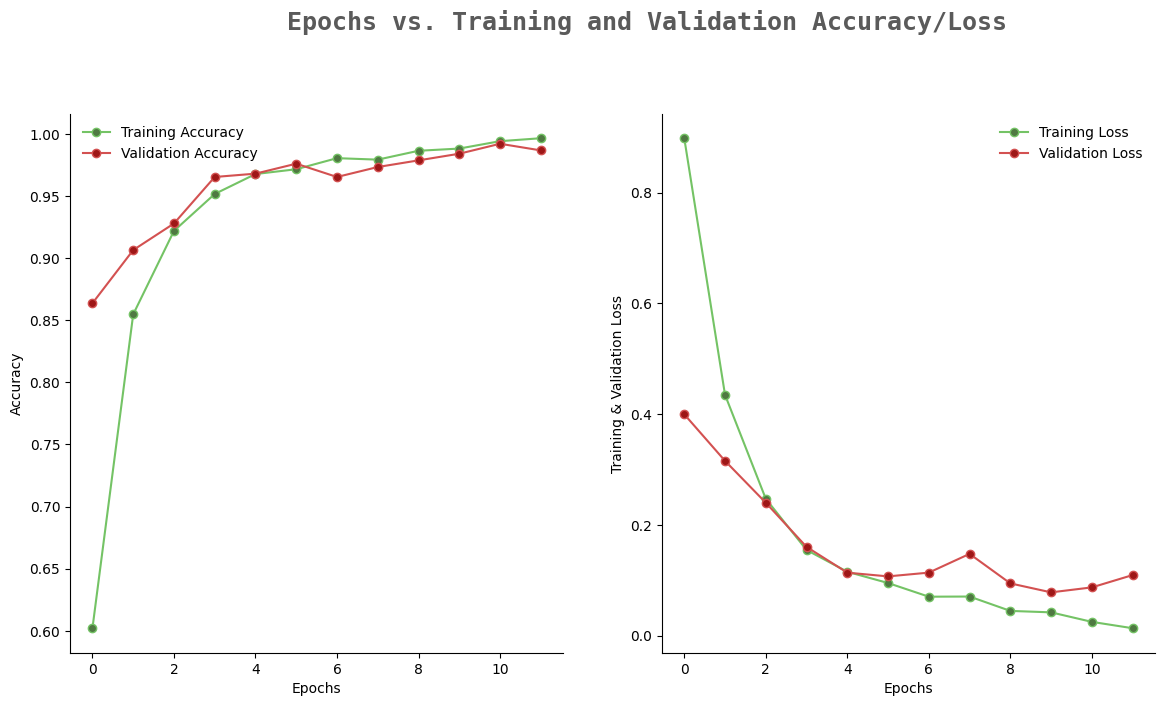

In [27]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [28]:
model.evaluate(X_test_features, y_test)

30/30 [==============================] - 8s 259ms/step - loss: 0.1442 - accuracy: 0.9882


[0.14421194791793823, 0.9882352948188782]

In [29]:
pred = model.predict(X_test_features)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

30/30 [==============================] - 11s 350ms/step


In [30]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       352
           1       0.97      1.00      0.98       224
           2       1.00      0.98      0.99       359

    accuracy                           0.99       935
   macro avg       0.99      0.99      0.99       935
weighted avg       0.99      0.99      0.99       935



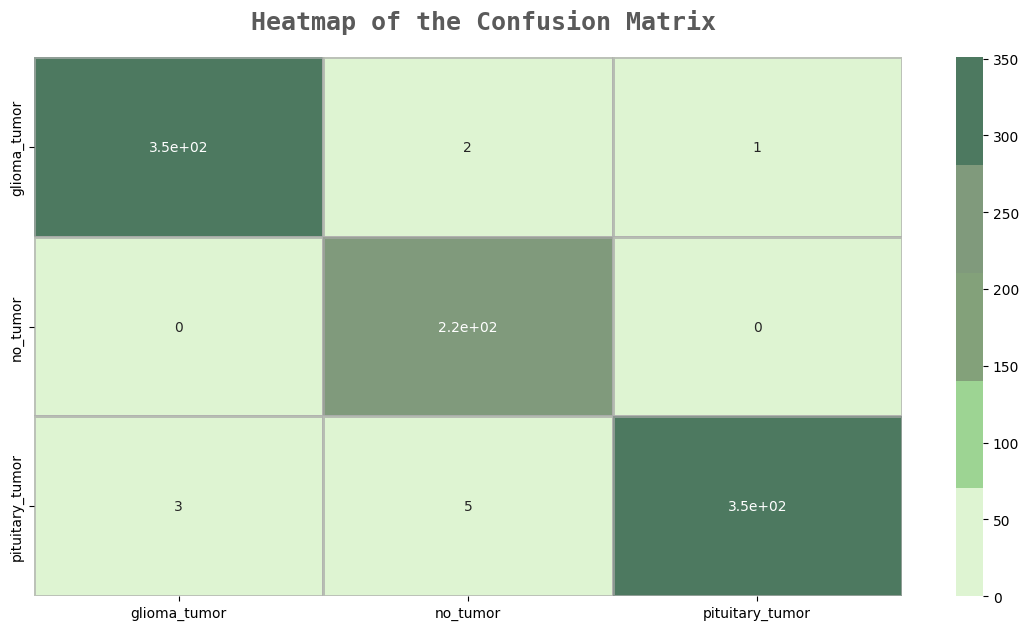

In [31]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True, cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)
plt.show()